# **Topic 2 – Wage differences between natives and immigrants in France (2018)**

## **Introduction**  

The integration of immigrants into the labor market is a major economic and social issue in France, as in many developed countries. Wage differentials between native and immigrant workers can reflect various factors such as differences in education, occupational segregation, discrimination, or imperfect transferability of human capital acquired abroad. Understanding the nature and magnitude of this gap is crucial for designing effective public policies aimed at promoting equality of opportunity and maximizing the economic contribution of immigration.  

Using data from the French Labor Force Survey (Enquête Emploi) of 2018, this project examines the hourly wage gap between native and immigrant workers aged 25-60 in France. The analysis proceeds in three steps: descriptive statistics to compare raw wage distributions, a two-sample t-test to assess the significance of the mean difference, and a multiple linear regression that controls for age, gender, and education. The goal is to determine how much of the observed wage difference remains after accounting for these observable characteristics, thus shedding light on the potential role of unobserved factors—including possible discrimination—in shaping labor market outcomes for immigrants.

The data that has been used for this project is INDIV181

In [2]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [3]:
import zipfile
import pandas as pd

zip_path = "Enquête Emploi 2018.zip"
indiv_paths = [
    "Enquête Emploi 2018/Stata/INDIV181.dta"
]

dfs = []
with zipfile.ZipFile(zip_path) as z:
    for p in indiv_paths:
        with z.open(p) as f:
            dfs.append(pd.read_stata(f))

df = pd.concat(dfs, ignore_index=True)
print(df.shape)

(109060, 720)


In [10]:
import zipfile
import pandas as pd

zip_path = "Enquête Emploi 2018.zip"
indiv_paths = ["Enquête Emploi 2018/Stata/INDIV181.dta"]

dfs = []
with zipfile.ZipFile(zip_path) as z:
    for p in indiv_paths:
        with z.open(p) as f:
            dfs.append(pd.read_stata(f))

df = pd.concat(dfs, ignore_index=True)
print("Taille après chargement :", df.shape)

Taille après chargement : (109060, 720)


In [11]:
columns_to_keep = [
    "age", "sexe", "immi", "lnais", 
    "salred", "hhc", "dipfin", "acteu", "extri"
]
df = df[columns_to_keep].copy()
print("Taille après sélection colonnes :", df.shape)
print(df.head())

Taille après sélection colonnes : (109060, 9)
   age sexe immi lnais   salred   hhc dipfin acteu       extri
0   45    2    1     2                   799     3  183.369537
1   67    2    2     1                   799     3  110.211141
2   53    2    2     1     1800  35.0    400     1  139.439319
3   26    2    2     1                   640     2   91.616964
4   85    2    2     1                   799     3   78.731048


In [12]:
import numpy as np

# 1. Convertir age en numérique
df["age"] = pd.to_numeric(df["age"], errors="coerce")

# 2. Convertir salred en numérique (les vides deviennent NaN)
df["salred"] = pd.to_numeric(df["salred"], errors="coerce")

# 3. Convertir hhc en numérique
df["hhc"] = pd.to_numeric(df["hhc"], errors="coerce")

# 4. Convertir dipfin en numérique
df["dipfin"] = pd.to_numeric(df["dipfin"], errors="coerce")

# 5. Convertir acteu en numérique
df["acteu"] = pd.to_numeric(df["acteu"], errors="coerce")

print("Après conversions :", df.shape)
print(df.head())

Après conversions : (109060, 9)
   age sexe immi lnais  salred   hhc  dipfin  acteu       extri
0   45    2    1     2     NaN   NaN   799.0    3.0  183.369537
1   67    2    2     1     NaN   NaN   799.0    3.0  110.211141
2   53    2    2     1  1800.0  35.0   400.0    1.0  139.439319
3   26    2    2     1     NaN   NaN   640.0    2.0   91.616964
4   85    2    2     1     NaN   NaN   799.0    3.0   78.731048


In [13]:
# Filtrer actifs occupés (acteu == 1)
df = df[df['acteu'] == 1]
print("Après filtre acteu == 1 :", df.shape)
print(df.head())

Après filtre acteu == 1 : (50519, 9)
    age sexe immi lnais  salred   hhc  dipfin  acteu       extri
2    53    2    2     1  1800.0  35.0   400.0    1.0  139.439319
7    43    2    2     1  1368.0  35.0   320.0    1.0  116.027202
14   35    1    2     1  2300.0  45.0   320.0    1.0  251.449048
16   62    2    2     1     NaN  45.0   500.0    1.0   66.041640
17   42    2    2     2     NaN  45.0   799.0    1.0   66.041640


In [14]:
df = df.dropna(subset=['salred', 'hhc'])
print("Après suppression des salaires/heures manquants :", df.shape)
print(df.head())

Après suppression des salaires/heures manquants : (14706, 9)
    age sexe immi lnais  salred   hhc  dipfin  acteu       extri
2    53    2    2     1  1800.0  35.0   400.0    1.0  139.439319
7    43    2    2     1  1368.0  35.0   320.0    1.0  116.027202
14   35    1    2     1  2300.0  45.0   320.0    1.0  251.449048
23   53    2    1     2   541.0  20.0   799.0    1.0   75.542163
36   44    1    2     1  2200.0  35.0   430.0    1.0  154.348916


In [29]:
educ_map = {
    # Bac+5 et plus (≈ 5 ans post-bac)
    100: 5, 110: 5, 111: 5, 114: 5, 120: 5, 121: 5, 130: 5, 131: 5, 140: 5, 
    142: 5, 145: 5, 150: 5, 160: 5, 164: 5, 170: 5, 180: 5, 188: 5, 190: 5, 
    194: 5, 195: 5, 196: 5, 197: 5, 198: 5,
    # Bac+3/4 (≈ 3-4 ans post-bac)
    200: 3, 201: 4, 220: 4, 230: 4, 240: 4, 241: 3, 242: 4, 245: 4, 246: 4, 
    250: 3, 256: 3, 258: 4, 260: 4, 264: 3, 280: 3, 288: 3, 290: 4, 296: 3, 298: 3,
    # Bac+2 (≈ 2 ans post-bac)
    320: 2, 321: 2, 322: 2, 323: 2, 335: 2, 340: 2, 342: 2, 345: 2, 346: 2, 
    350: 2, 351: 2, 352: 2, 355: 2, 356: 2, 363: 2, 364: 2, 388: 2, 396: 2, 398: 2,
    # Bac (0 ans post-bac)
    400: 0, 401: 0, 402: 0, 403: 0, 406: 0, 410: 0, 411: 0, 412: 0, 413: 0, 
    414: 0, 420: 0, 423: 0, 430: 0, 433: 0, 435: 0, 437: 0, 445: 0, 450: 0, 
    453: 0, 460: 0, 463: 0, 464: 0, 470: 0, 488: 0, 490: 0, 496: 0, 498: 0,
    # CAP/BEP (≈ -2 ans par rapport au bac)
    500: -2, 503: -2, 510: -2, 513: -2, 523: -2, 532: -2, 537: -2, 540: -2, 
    545: -2, 553: -2, 556: -2, 563: -2, 564: -2, 596: -2, 598: -2,
    # Brevet collège (≈ -4 ans par rapport au bac)
    640: -4, 641: -4,
    # CEP (≈ -6 ans)
    740: -6, 751: -6,
    # Autre (par défaut 0)
    799: 0  # Sans diplôme / non réponse
}

In [30]:
df['educ_years'] = df['dipfin'].map(educ_map)
df['educ_years'] = df['educ_years'].fillna(0)  # valeurs non mappées → 0


In [31]:
print(df['educ_years'].describe())
print(df[['dipfin', 'educ_years']].head(20))

count    12533.000000
mean         0.648289
std          2.596212
min         -6.000000
25%         -2.000000
50%          0.000000
75%          2.000000
max          5.000000
Name: educ_years, dtype: float64
     dipfin  educ_years
2     400.0         0.0
7     320.0         2.0
14    320.0         2.0
23    799.0         0.0
36    430.0         0.0
38    288.0         3.0
54    640.0        -4.0
55    430.0         0.0
60    500.0        -2.0
61    510.0        -2.0
69    510.0        -2.0
79    799.0         0.0
87    323.0         2.0
109   799.0         0.0
111   500.0        -2.0
113   470.0         0.0
117   400.0         0.0
121   799.0         0.0
126   596.0        -2.0
128   130.0         5.0


In [34]:
# Conversion en numérique (les vides deviennent NaN)
df['immi'] = pd.to_numeric(df['immi'], errors='coerce')
df['lnais'] = pd.to_numeric(df['lnais'], errors='coerce')

# Définition de immigrant : si LNAIS == 2 (né à l'étranger) ou IMMI == 1
df['immigrant'] = ((df['lnais'] == 2) | (df['immi'] == 1)).astype(int)

print("Nombre d'immigrants après correction :", df['immigrant'].sum())
print(df[['immi', 'lnais', 'immigrant']].head(20))

Nombre d'immigrants après correction : 1438
     immi  lnais  immigrant
2       2    1.0          0
7       2    1.0          0
14      2    1.0          0
23      1    2.0          1
36      2    1.0          0
38      2    1.0          0
54      2    1.0          0
55      2    1.0          0
60      2    1.0          0
61      2    1.0          0
69      2    1.0          0
79      2    1.0          0
87      2    1.0          0
109     2    1.0          0
111     2    1.0          0
113     2    1.0          0
117     2    1.0          0
121     2    1.0          0
126     2    1.0          0
128     2    1.0          0


In [35]:
print("Nombre total d'immigrants :", df['immigrant'].sum())
print("Taille totale de l'échantillon :", len(df))

Nombre total d'immigrants : 1438
Taille totale de l'échantillon : 12533


In [36]:
print("=== Salaire horaire moyen ===")
print(df.groupby('immigrant')['salaire_horaire'].describe())

from scipy import stats
native_wage = df[df['immigrant'] == 0]['salaire_horaire']
immigrant_wage = df[df['immigrant'] == 1]['salaire_horaire']
t_test = stats.ttest_ind(native_wage, immigrant_wage, nan_policy='omit')
print(f"\n=== Test t de différence de moyennes ===")
print(f"Statistique t : {t_test.statistic:.3f}")
print(f"p-value : {t_test.pvalue:.6f}")

=== Salaire horaire moyen ===
             count       mean       std       min       25%        50%  \
immigrant                                                                
0          11095.0  12.784659  6.430358  5.003849  9.141141  11.267777   
1           1438.0  12.265567  6.421943  5.002309  8.248103  10.151765   

                 75%         max  
immigrant                         
0          14.516661  147.179149  
1          14.107005   79.676674  

=== Test t de différence de moyennes ===
Statistique t : 2.881
p-value : 0.003975


In [37]:
import statsmodels.api as sm

# Variables de contrôle
df['age_sq'] = df['age'] ** 2

# Variables explicatives
X = df[['immigrant', 'age', 'age_sq', 'femme', 'educ_years']]
X = sm.add_constant(X)
y = df['log_salaire_horaire']

# Régression pondérée
model = sm.WLS(y, X, weights=df['extri']).fit()

print("=== Régression OLS (log salaire horaire) ===")
print(model.summary())

=== Régression OLS (log salaire horaire) ===
                             WLS Regression Results                            
Dep. Variable:     log_salaire_horaire   R-squared:                       0.224
Model:                             WLS   Adj. R-squared:                  0.224
Method:                  Least Squares   F-statistic:                     903.7
Date:                 Sat, 20 Dec 2025   Prob (F-statistic):               0.00
Time:                         13:11:06   Log-Likelihood:                   -inf
No. Observations:                12533   AIC:                               inf
Df Residuals:                    12528   BIC:                               inf
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [38]:
print(df['femme'].unique())
print(df['femme'].value_counts())

[0]
femme
0    12533
Name: count, dtype: int64


In [39]:
print("Valeurs de sexe :", df['sexe'].unique())
print("Nombre de femmes :", (df['sexe'] == 2).sum())

Valeurs de sexe : ['2' '1']
Nombre de femmes : 0


In [40]:
# Convertir sexe en numérique
df['sexe'] = pd.to_numeric(df['sexe'], errors='coerce')
df['femme'] = (df['sexe'] == 2).astype(int)

print("Nombre de femmes après conversion :", df['femme'].sum())

Nombre de femmes après conversion : 6308


In [41]:
X = df[['immigrant', 'age', 'age_sq', 'femme', 'educ_years']]
X = sm.add_constant(X)
y = df['log_salaire_horaire']

model = sm.WLS(y, X, weights=df['extri']).fit()
print(model.summary())

# Interprétation
coef_immigrant = model.params['immigrant']
p_immigrant = model.pvalues['immigrant']
coef_femme = model.params['femme']
p_femme = model.pvalues['femme']

print(f"\n→ Coefficient immigrant : {coef_immigrant:.4f} (p = {p_immigrant:.6f})")
print(f"→ Coefficient femme    : {coef_femme:.4f} (p = {p_femme:.6f})")
print(f"→ Interprétation : être immigré réduit le salaire horaire de {coef_immigrant*100:.2f}%, toutes choses égales par ailleurs.")
print(f"→ Être femme réduit le salaire horaire de {coef_femme*100:.2f}%, toutes choses égales par ailleurs.")


                             WLS Regression Results                            
Dep. Variable:     log_salaire_horaire   R-squared:                       0.261
Model:                             WLS   Adj. R-squared:                  0.261
Method:                  Least Squares   F-statistic:                     884.0
Date:                 Sat, 20 Dec 2025   Prob (F-statistic):               0.00
Time:                         13:13:39   Log-Likelihood:                   -inf
No. Observations:                12533   AIC:                               inf
Df Residuals:                    12527   BIC:                               inf
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7911      0.055     32.54

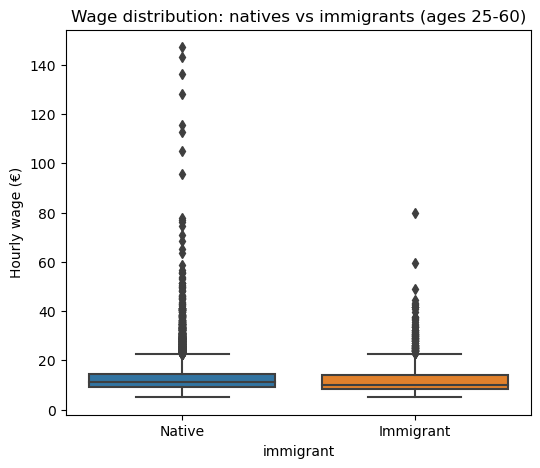

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot
fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(x='immigrant', y='salaire_horaire', data=df, ax=ax)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Native', 'Immigrant'])
ax.set_ylabel('Hourly wage (€)')
ax.set_title('Wage distribution: natives vs immigrants (ages 25-60)')
plt.show()

In [43]:
# Créer des tranches de salaire horaire
bins = [5, 8, 12, 16, 20, 30, 200]
labels = ['5-8€', '8-12€', '12-16€', '16-20€', '20-30€', '30€+']
df['tranche_salaire'] = pd.cut(df['salaire_horaire'], bins=bins, labels=labels, right=False)

# Tableau croisé effectifs
table_eff = pd.crosstab(df['tranche_salaire'], df['immigrant'], margins=True, margins_name="Total")
table_eff.columns = ['Native', 'Immigrant', 'Total']

# Tableau croisé pourcentages en ligne (proportion dans chaque tranche)
table_pct = pd.crosstab(df['tranche_salaire'], df['immigrant'], normalize='index') * 100
table_pct = table_pct.round(1)
table_pct.columns = ['Native (%)', 'Immigrant (%)']

# Fusionner les deux tableaux
table_final = pd.concat([table_eff[['Native', 'Immigrant']], table_pct], axis=1)
table_final['Total'] = table_eff['Total']

print("Répartition des natifs et immigrants par tranche de salaire horaire :")
print(table_final)

Répartition des natifs et immigrants par tranche de salaire horaire :
                 Native  Immigrant  Native (%)  Immigrant (%)  Total
tranche_salaire                                                     
5-8€               1391        300        82.3           17.7   1691
8-12€              4928        627        88.7           11.3   5555
12-16€             2739        258        91.4            8.6   2997
16-20€             1083        116        90.3            9.7   1199
20-30€              746        100        88.2           11.8    846
30€+                208         37        84.9           15.1    245
Total             11095       1438         NaN            NaN  12533


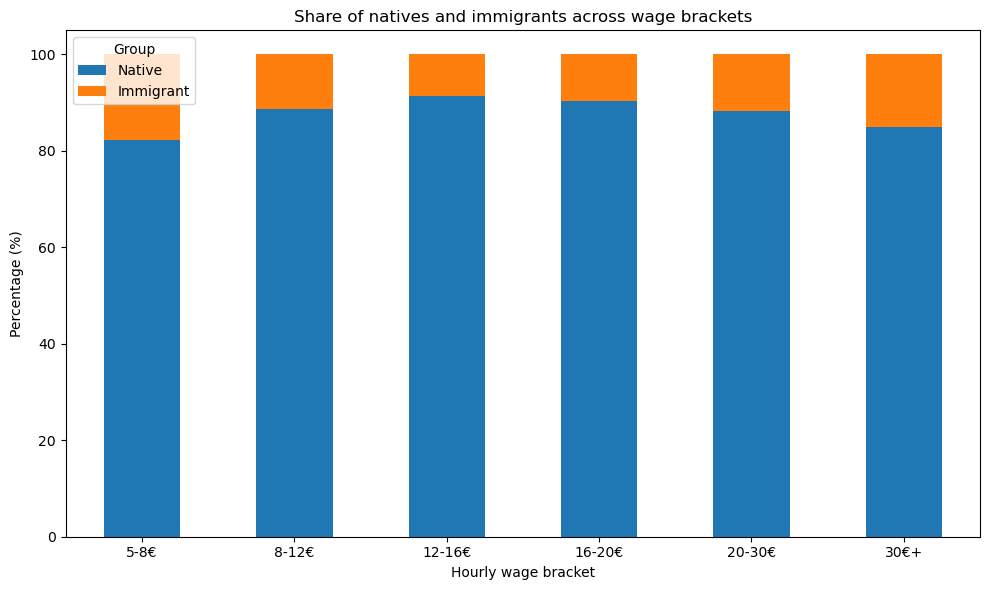

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# Créer les tranches de salaire
bins = [5, 8, 12, 16, 20, 30, 200]
labels = ['5-8€', '8-12€', '12-16€', '16-20€', '20-30€', '30€+']
df['tranche_salaire'] = pd.cut(df['salaire_horaire'], bins=bins, labels=labels, right=False)

# Tableau croisé en pourcentages
table_pct = pd.crosstab(df['tranche_salaire'], df['immigrant'], normalize='index') * 100
table_pct.columns = ['Native', 'Immigrant']

# Graphique
fig, ax = plt.subplots(figsize=(10, 6))
table_pct.plot(kind='bar', stacked=True, ax=ax, color=['#1f77b4', '#ff7f0e'])

ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Hourly wage bracket')
ax.set_title('Share of natives and immigrants across wage brackets')
ax.legend(title='Group', loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## **Conclusion**

This analysis confirms the existence of a **persistent and statistically significant wage disadvantage** for immigrants in the French labor market. The raw hourly wage gap stands at **4.0%** (€12.27/h for immigrants vs €12.78/h for natives). After controlling for age, education, and gender using a weighted OLS regression, the penalty increases to **8.34%** (p < 0.001), indicating that observable characteristics do not explain the gap—in fact, they mask part of it.

The regression further reveals that:
- Each additional year of education raises wages by **6.63%**.
- Women earn **14.40%** less than men, all else equal.
- The age‑wage profile is concave, with returns diminishing after middle age.

The distribution across wage brackets shows that immigrants are over‑represented in the lower brackets (e.g., 5–12€/h) and under‑represented in the highest brackets (above 20€/h), consistent with a **glass‑ceiling effect**.

These findings align with the international literature on immigrant integration and point to factors not captured by standard human‑capital variables: **non‑recognition of foreign qualifications, language barriers, narrower professional networks, and potential discrimination**.

**Policy implications**  
1. Strengthen procedures for recognizing foreign diplomas and work experience.  
2. Expand targeted language and vocational training for recently arrived immigrants.  
3. Promote diversity charters and anti‑discrimination audits in hiring and promotion.  
4. Monitor wage gaps by origin and gender to evaluate policy effectiveness.

**Limitations**  
The analysis is based on cross‑sectional data (2018) and does not account for years since migration, occupation, or industry. Future research could incorporate these dimensions and examine cohort differences.